In [1]:
# 참고
#https://deep-deep-deep.tistory.com/60

In [2]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam


physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

2022-07-06 08:49:08.801455: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-06 08:49:08.824629: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-06 08:49:08.825057: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
if not os.path.exists('./TIME_SERIES/'):
    os.mkdir('./TIME_SERIES/')
if not os.path.exists('./TIME_SERIES/WEATHER_ASOS_TIME_2006_2206/'):
    os.mkdir('./TIME_SERIES/WEATHER_ASOS_TIME_2006_2206/')
if not os.path.exists('./TIME_SERIES/CLEAN_WEATHER_ASOS_TIME_2006_2206/'):
    os.mkdir('./TIME_SERIES/CLEAN_WEATHER_ASOS_TIME_2006_2206/')
    
print(os.getcwd())

/home/alfa_members/hyunjo/tensorflow2


In [4]:
# <---------------- Google Colab에서 돌릴 경우 ----------------> 

# from google.colab import drive
# drive.mount('/content/drive')

## 여기 변경 (22-07-06 16:00)

In [5]:
dict_args = dict()
dict_args['raw_file'] = './TIME_SERIES/WEATHER_ASOS_TIME_2006_2206/WEATHER_ASOS_2205.csv'  # 필요시 경로 변경
dict_args['preprocessed_file'] = './TIME_SERIES/CLEAN_WEATHER_ASOS_TIME_2006_2206/CLEAN_WEATHER_ASOS_2205.csv'  # 필요시 경로 변경
dict_args['min_max_file'] = './TIME_SERIES/min_max.csv'
dict_args["window_size"] = 4
dict_args["features"] = ['기온(°C)','풍속(m/s)','습도(%)']
dict_args["label"] = ['기온(°C)']
dict_args["index"] = ['지점','지점명','일시']
dict_args["area"] = "속초"
dict_args["test_size"] = 120
## 여기 변경 (22-07-06 16:00)
dict_args['model_file'] = './TIME_SERIES/MODEL2/'
dict_args["param_list"] =  {
                            "LSTM": {'epochs': 60,
                                      'batch_size': 50,
                                      'learning_rate': 0.0005,
                                    },
                            "GRU": 
                                    {'epochs': 60,
                                      'batch_size': 50,
                                      'learning_rate': 0.0005,
                                    },
                            }


## 여기 변경 (22-07-06 16:00)

In [6]:
english_var = {
    '기온(°C)' :  'Temp(°C)',
    '강수량(mm)' :  'WaterFall(mm)',
    '풍속(m/s)' :  'WindSpeed(m/s)',
    '풍향(16방위)' :  'WindDir(16)',
    '습도(%)' :  'Dampness(%)',
    '증기압(hPa)' :  'AirPressure(hPa)',
    '이슬점온도(°C)' :  'DewPointTemp(°C)',
    '현지기압(hPa)' :  'LocalPressure(hPa)',
    '해면기압(hPa)' :  'SeaLevelPressure(hPa)',
    '일조(hr)' :  'SunShine(hr)',
    '일사(MJ/m2)' :  'Radiation(MJ/m2)',
    '적설(cm)' :  'Snow(cm)',
    '3시간신적설(cm)' :  '3hrsSnow(cm)',
    '전운량(10분위)' :  'FullCloud(10)',
    '중하층운량(10분위)' :  'LowMiddleCloud(10)',
    '운형(운형약어)' :  'CloudShape',
}

print(english_var)

{'기온(°C)': 'Temp(°C)', '강수량(mm)': 'WaterFall(mm)', '풍속(m/s)': 'WindSpeed(m/s)', '풍향(16방위)': 'WindDir(16)', '습도(%)': 'Dampness(%)', '증기압(hPa)': 'AirPressure(hPa)', '이슬점온도(°C)': 'DewPointTemp(°C)', '현지기압(hPa)': 'LocalPressure(hPa)', '해면기압(hPa)': 'SeaLevelPressure(hPa)', '일조(hr)': 'SunShine(hr)', '일사(MJ/m2)': 'Radiation(MJ/m2)', '적설(cm)': 'Snow(cm)', '3시간신적설(cm)': '3hrsSnow(cm)', '전운량(10분위)': 'FullCloud(10)', '중하층운량(10분위)': 'LowMiddleCloud(10)', '운형(운형약어)': 'CloudShape'}


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

%matplotlib inline

plt.rcParams["figure.figsize"] = (15,15)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.grid'] = False
plt.rcParams['font.size'] = 8
plt.rcParams['font.family'] = 'NanumGothic'


def draw_graph(df): 
    fig, axes = plt.subplots(4, 4, sharex=False)

    sns.distplot(df['Temp(°C)' ], bins=70, kde=False, ax=axes[0,0])
    sns.distplot(df['WaterFall(mm)' ], bins=70, kde=False, ax=axes[0,1])
    sns.distplot(df['WindSpeed(m/s)' ], bins=70, kde=False, ax=axes[0,2])
    sns.distplot(df['WindDir(16)' ], bins=70, kde=False, ax=axes[0,3])
    sns.distplot(df['Dampness(%)' ], bins=70, kde=False, ax=axes[1,0])
    sns.distplot(df['AirPressure(hPa)' ], bins=70, kde=False, ax=axes[1,1])
    sns.distplot(df['DewPointTemp(°C)' ], bins=70, kde=False, ax=axes[1,2])
    sns.distplot(df['LocalPressure(hPa)' ], bins=70, kde=False, ax=axes[1,3])
    sns.distplot(df['SeaLevelPressure(hPa)' ], bins=70, kde=False, ax=axes[2,0])
    sns.distplot(df['SunShine(hr)' ], bins=70, kde=False, ax=axes[2,1])
    sns.distplot(df['Radiation(MJ/m2)' ], bins=70, kde=False, ax=axes[2,2])
    sns.distplot(df['Snow(cm)' ], bins=70, kde=False, ax=axes[2,3]) 
    sns.distplot(df['3hrsSnow(cm)' ], bins=70, kde=False, ax=axes[3,0])
    sns.distplot(df['FullCloud(10)' ], bins=70, kde=False, ax=axes[3,1])
    sns.distplot(df['LowMiddleCloud(10)' ], bins=70, kde=False, ax=axes[3,2])
    sns.distplot(df['CloudShape' ], bins=70, kde=False, ax=axes[3,3])
    
    plt.plot()

16


,Temp(°C),WaterFall(mm),WindSpeed(m/s),WindDir(16),Dampness(%),AirPressure(hPa),DewPointTemp(°C),LocalPressure(hPa),SeaLevelPressure(hPa),SunShine(hr),Radiation(MJ/m2),Snow(cm),3hrsSnow(cm),FullCloud(10),LowMiddleCloud(10),CloudShape
0,11.4,NaN,1.7,270.0,46.0,6.2,0.1,1011.7,1013.8,NaN,NaN,NaN,NaN,0.0,0.0,NaN
1,11.9,NaN,3.4,290.0,38.0,5.3,-1.9,1011.1,1013.2,NaN,NaN,NaN,NaN,0.0,0.0,NaN
2,10.7,NaN,2.7,290.0,46.0,5.9,-0.4,1010.9,1013.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN
3,10.5,NaN,1.9,250.0,44.0,5.6,-1.2,1010.7,1012.8,NaN,NaN,NaN,NaN,0.0,0.0,NaN
4,10.2,NaN,1.2,290.0,40.0,5.0,-2.8,1010.0,1012.1,NaN,NaN,NaN,NaN,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,24.3,NaN,2.6,270.0,23.0,7.0,1.8,1003.5,1005.5,0.0,NaN,NaN,NaN,7.0,2.0,NaN
740,22.8,NaN,1.6,50.0,28.0,7.7,3.3,1004.1,1006.1,NaN,NaN,NaN,NaN,6.0,0.0,NaN
741,22.7,NaN,1.9,110.0,23.0,6.3,0.4,1004.4,1006.4,NaN,NaN,NaN,NaN,7.0,4.0,NaN
742,23.2,NaN,1.0,250.0,18.0,5.1,-2.4,1004.3,1006.3,NaN,NaN,NaN,NaN,8.0,5.0,NaN


지점               0
지점명              0
일시               0
기온(°C)           0
기온 QC플래그       744
강수량(mm)        702
강수량 QC플래그      597
풍속(m/s)          0
풍속 QC플래그       744
풍향(16방위)         0
풍향 QC플래그       744
습도(%)            0
습도 QC플래그       744
증기압(hPa)         0
이슬점온도(°C)        0
현지기압(hPa)        0
현지기압 QC플래그     744
해면기압(hPa)        0
해면기압 QC플래그     744
일조(hr)         279
일조 QC플래그       465
일사(MJ/m2)      744
일사 QC플래그         0
적설(cm)         744
3시간신적설(cm)     744
전운량(10분위)        5
중하층운량(10분위)      2
운형(운형약어)       744
최저운고(100m )    516
dtype: int64


,지점,지점명,일시,기온(°C),풍속(m/s),습도(%),증기압(hPa),이슬점온도(°C),현지기압(hPa),해면기압(hPa)
0,90,속초,2022-05-01 01:00,11.4,1.7,46.0,6.2,0.1,1011.7,1013.8
1,90,속초,2022-05-01 02:00,11.9,3.4,38.0,5.3,-1.9,1011.1,1013.2
2,90,속초,2022-05-01 03:00,10.7,2.7,46.0,5.9,-0.4,1010.9,1013.0
3,90,속초,2022-05-01 04:00,10.5,1.9,44.0,5.6,-1.2,1010.7,1012.8
4,90,속초,2022-05-01 05:00,10.2,1.2,40.0,5.0,-2.8,1010.0,1012.1
...,...,...,...,...,...,...,...,...,...,...
739,90,속초,2022-05-31 20:00,24.3,2.6,23.0,7.0,1.8,1003.5,1005.5
740,90,속초,2022-05-31 21:00,22.8,1.6,28.0,7.7,3.3,1004.1,1006.1
741,90,속초,2022-05-31 22:00,22.7,1.9,23.0,6.3,0.4,1004.4,1006.4
742,90,속초,2022-05-31 23:00,23.2,1.0,18.0,5.1,-2.4,1004.3,1006.3


findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


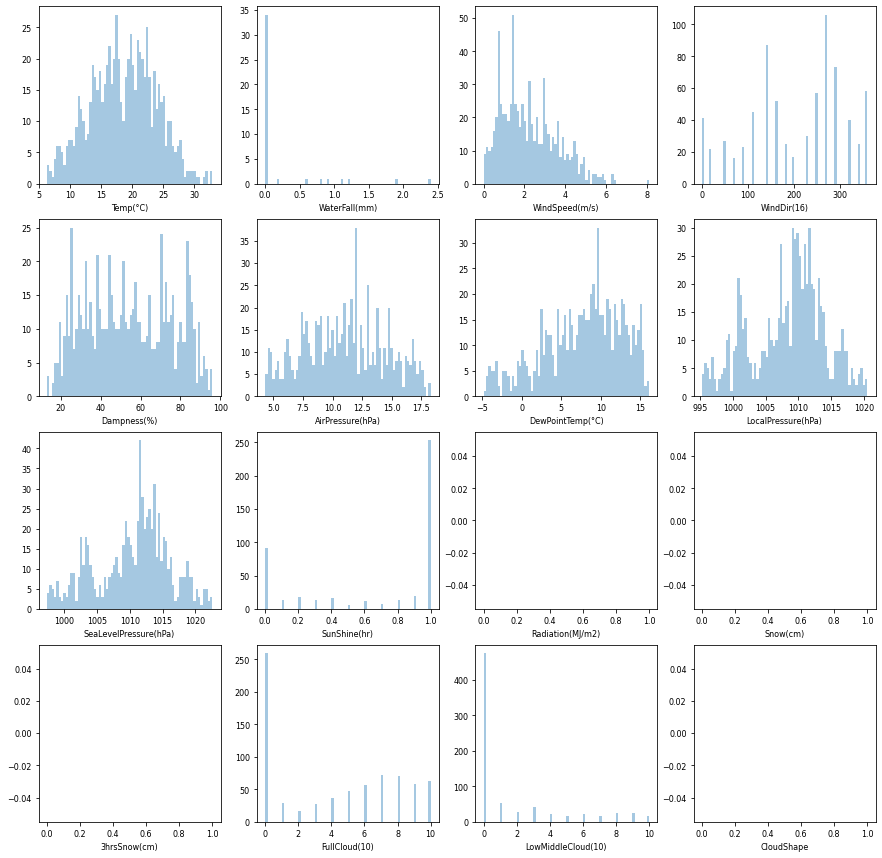

In [8]:
import seaborn as sns
aaa = pd.read_csv(dict_args['raw_file'], encoding='euc-kr')
# display(aaa)
aaa = aaa[aaa['지점명']==dict_args["area"]]
# print(aaa.columns.tolist())

# var distribution
graph_cols = ['기온(°C)', '강수량(mm)', '풍속(m/s)', '풍향(16방위)', '습도(%)', '증기압(hPa)', '이슬점온도(°C)', '현지기압(hPa)', '해면기압(hPa)', '일조(hr)', '일사(MJ/m2)','적설(cm)', 
 '3시간신적설(cm)', '전운량(10분위)', '중하층운량(10분위)', '운형(운형약어)']
print(len(graph_cols))


graph_df = aaa[graph_cols]
english_names = list()
for col in graph_df.columns.tolist():
    english_names.append(english_var.get(col))
graph_df.columns = english_names
display(graph_df)
draw_graph(graph_df)

print(aaa.isna().sum())

drop_columns = [
"기온 QC플래그",
"강수량(mm)",
"강수량 QC플래그",
"풍속 QC플래그",
"풍향(16방위)",
"풍향 QC플래그",
"습도 QC플래그",
"현지기압 QC플래그",
"해면기압 QC플래그",
"일조(hr)",
"일조 QC플래그",
"일사(MJ/m2)",
"일사 QC플래그",
"적설(cm)",
"3시간신적설(cm)",
"전운량(10분위)",
"중하층운량(10분위)",
"운형(운형약어)",
"최저운고(100m )"
]


# 변수 더 추가해서 새로 Raw_File 지정된 경로에 저장
dict_args['allVar_raw_file'] = './TIME_SERIES/WEATHER_ASOS_TIME_2006_2206/allVar_WEATHER_ASOS_2205.csv'  # 필요시 경로 변경

aaa = aaa.drop(drop_columns, axis=1)
display(aaa)
aaa.to_csv(dict_args['allVar_raw_file'], index=None)

In [9]:
def make_preprocessed_file(p_args):
    
    try: 
        df = pd.read_csv(p_args['allVar_raw_file'], encoding='utf-8') 
    except:
        df = pd.read_csv(p_args['allVar_raw_file'], encoding='euc-kr')     
    # display(df)
    # print(df.columns)
    columns = p_args['index']
    columns.extend(p_args["features"])
    print(columns)

    df = df[columns]
    df = df[df['지점명'] == p_args["area"]] 
    df.index = pd.to_datetime(df['일시'], format='%Y-%m-%d %H:%S')

    df = df[p_args["features"]]
    df = df.astype('float32')
    print(df.info())
    print(df.isna().sum())
    display(df)
    df.to_csv(p_args['preprocessed_file'], encoding='utf-8')


def make_dataset_regression(data, label, window_size):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        # print('feature list: ', np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
        # print('label list: ', np.array(data.iloc[i:i+window_size])) 
    return np.array(feature_list), np.array(label_list)


def split_dataset_regression(p_args, scaling_flag=True):
    # 파일 읽기
    df = pd.read_csv(p_args["preprocessed_file"])
    df = df.fillna(0)
    df = df.set_index('일시')
    df = df.astype(float)

    # 수치 정규화 
    if scaling_flag: 
        print('정규화된 데이터입니다.')
        df_scaled = df.copy()
        
        min_max_df = pd.DataFrame() 
        for col in df_scaled.columns:
            min_ = np.min(df_scaled[col])
            max_ = np.max(df_scaled[col])

            min_max_dict = dict()
            scaled_list = list()
            for x in df_scaled[col]:
                scaled_x = (x - min_) / (max_ - min_)
                scaled_list.append(scaled_x)
            df_scaled[col] = scaled_list   
            
            min_max_dict['VAR'] = col
            min_max_dict['min'] = min_
            min_max_dict['max'] = max_            
                
            min_max_list = []
            min_max_list.append(min_max_dict)
            tmpdf = pd.DataFrame(min_max_list)
            # display(tmpdf)
            min_max_df = pd.concat([min_max_df, tmpdf], axis=0) 
                
        # 중간에 MIN_MAX 파일로 저장 (나중에 원래 수치로 다시 계산할때 필요)
        min_max_df.to_csv(p_args["min_max_file"], index=None, encoding='utf-8')

    else:
        print('정규화가 제외된 데이터입니다.')
        df_scaled = df.copy()
        # display(df_scaled.head(5))
    
    # Train과 Test 분리
    train = df_scaled[:-p_args["test_size"]]
    test = df_scaled[-p_args["test_size"]:]
    print("train: ", train.shape, type(train))
    print("test: ", test.shape, type(test))
    # display(train.head(5))
    # display(test.head(5))
    
    train_feature, train_label = make_dataset_regression(train[dict_args["features"]], train[dict_args["label"]], window_size = p_args["window_size"])
    print("train_feature: ", train_feature.shape, type(train_feature))
    print("train_label: ", train_label.shape, type(train_label))
    
    # Train에서 Train Set, Valid Set 분리 (검증셋)
    from sklearn.model_selection import train_test_split
    X_train, X_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size = 0.2)
    
    y_train = y_train.reshape(len(y_train))
    y_valid = y_valid.reshape(len(y_valid))
    X_train = X_train.astype(float)
    y_train = y_train.astype(float)
    X_valid = X_valid.astype(float)
    y_valid = y_valid.astype(float)

    print("X_train: ",  X_train.shape, type(X_train))
    print("y_train: ",  y_train.shape, type(y_train))
    print("X_valid: ",  X_valid.shape, type(X_valid))
    print("y_valid: ",  y_valid.shape, type(y_valid))
    
    # Test set에서 feature, label 분리
    X_test, y_test = make_dataset_regression(test[dict_args["features"]], test[dict_args["label"]], window_size = p_args["window_size"])
    y_test = y_test.reshape(len(y_test))
    print("X_test: ", X_test.shape)
    print("y_test: ", y_test.shape)
    
    print(X_train[0])
    print(y_train[0])

    return train, test, train_feature, train_label, X_train, y_train, X_valid, y_valid, X_test, y_test


def build_LSTM_model(p_args, train_set):
    model = Sequential()
    model.add(LSTM(32, 
              input_shape=(train_set.shape[1], train_set.shape[2]),
              activation='relu',
              return_sequences=False))
    model.add(Dense(4, 'relu'))
    model.add(Dense(1))
    print(model.summary())

    # cp = ModelCheckpoint(p_args['model_file'], save_best_only=True)
    model.compile(loss='mean_squared_error', 
                  optimizer= Adam(learning_rate=dict_args["param_list"]["LSTM"]["learning_rate"]), 
                  metrics=['mae'],
                  )
    return model


# min_max scaled values back to original values
def reverse_minmax(label, min_, max_):
    result_list = list()
    for element in label:
        new_element = element * (max_ - min_) + min_
        result_list.append(new_element)
    result_array = np.array(result_list)
    return result_array

In [10]:
train, test, train_feature, train_label, X_train, y_train, X_valid, y_valid, X_test, y_test = split_dataset_regression(dict_args, scaling_flag=True)

정규화된 데이터입니다.
train:  (624, 3) <class 'pandas.core.frame.DataFrame'>
test:  (120, 3) <class 'pandas.core.frame.DataFrame'>
train_feature:  (620, 4, 3) <class 'numpy.ndarray'>
train_label:  (620, 1) <class 'numpy.ndarray'>
X_train:  (496, 4, 3) <class 'numpy.ndarray'>
y_train:  (496,) <class 'numpy.ndarray'>
X_valid:  (124, 4, 3) <class 'numpy.ndarray'>
y_valid:  (124,) <class 'numpy.ndarray'>
X_test:  (116, 4, 3)
y_test:  (116,)
[[0.5917603  0.32098765 0.19277108]
 [0.62546816 0.2962963  0.1686747 ]
 [0.60674157 0.27160494 0.13253012]
 [0.57677903 0.09876543 0.08433735]]
0.5692883895131086


In [11]:
make_preprocessed_file(dict_args)

['지점', '지점명', '일시', '기온(°C)', '풍속(m/s)', '습도(%)']
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 744 entries, 2022-05-01 01:00:00 to 2022-06-01 00:00:00
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   기온(°C)   744 non-null    float32
 1   풍속(m/s)  744 non-null    float32
 2   습도(%)    744 non-null    float32
dtypes: float32(3)
memory usage: 14.5 KB
None
기온(°C)     0
풍속(m/s)    0
습도(%)      0
dtype: int64


,기온(°C),풍속(m/s),습도(%)
일시,,,
2022-05-01 01:00:00,11.400000,1.7,46.0
2022-05-01 02:00:00,11.900000,3.4,38.0
2022-05-01 03:00:00,10.700000,2.7,46.0
2022-05-01 04:00:00,10.500000,1.9,44.0
2022-05-01 05:00:00,10.200000,1.2,40.0
...,...,...,...
2022-05-31 20:00:00,24.299999,2.6,23.0
2022-05-31 21:00:00,22.799999,1.6,28.0
2022-05-31 22:00:00,22.700001,1.9,23.0


## 여기 변경 (22-07-06 16:00)

In [12]:
# model1 = build_LSTM_model(dict_args, X_train)
# # cp1 = LSTM_model(dict_args, X_train)
# # print(cp1)

# epochs = dict_args["param_list"]["LSTM"]["epochs"]
# batch_size = dict_args["param_list"]["LSTM"]["batch_size"]

# model1.fit(X_train, y_train, validation_data=(X_valid, y_valid), 
#            epochs=epochs, 
#            batch_size=batch_size,
#            callbacks=[ModelCheckpoint(dict_args['model_file'], save_best_only=True)],
# ) 

In [13]:
model2 = build_LSTM_model(dict_args, X_train)
# cp1 = LSTM_model(dict_args, X_train)
# print(cp1)

epochs = dict_args["param_list"]["LSTM"]["epochs"]
batch_size = dict_args["param_list"]["LSTM"]["batch_size"]

model2.fit(X_train, y_train, validation_data=(X_valid, y_valid), 
           epochs=epochs, 
           batch_size=batch_size,
           callbacks=[ModelCheckpoint(dict_args['model_file'], save_best_only=True)],
) 

2022-07-06 08:49:11.787718: I tensorflow/core/platform/cpu_feature_guard.cc:152] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-06 08:49:11.788535: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-06 08:49:11.789001: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-06 08:49:11.789401: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4608      
                                                                 
 dense (Dense)               (None, 4)                 132       
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
Total params: 4,745
Trainable params: 4,745
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/60


2022-07-06 08:49:13.591443: I tensorflow/stream_executor/cuda/cuda_blas.cc:1804] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


 1/10 [==>...........................] - ETA: 12s - loss: 0.2638 - mae: 0.4818

2022-07-06 08:49:14.332967: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


10/10 [==============================] - 2s 122ms/step - loss: 0.2076 - mae: 0.4189 - val_loss: 0.1842 - val_mae: 0.3851
Epoch 2/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.1949 - mae: 0.4045INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


10/10 [==============================] - 1s 109ms/step - loss: 0.1740 - mae: 0.3766 - val_loss: 0.1505 - val_mae: 0.3401
Epoch 3/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.1561 - mae: 0.3484INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


10/10 [==============================] - 1s 100ms/step - loss: 0.1385 - mae: 0.3257 - val_loss: 0.1181 - val_mae: 0.2962
Epoch 4/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.1019 - mae: 0.2571INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


10/10 [==============================] - 1s 100ms/step - loss: 0.1050 - mae: 0.2750 - val_loss: 0.0891 - val_mae: 0.2517
Epoch 5/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0972 - mae: 0.2747INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


10/10 [==============================] - 1s 111ms/step - loss: 0.0773 - mae: 0.2315 - val_loss: 0.0666 - val_mae: 0.2150
Epoch 6/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0542 - mae: 0.1936INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


10/10 [==============================] - 1s 93ms/step - loss: 0.0571 - mae: 0.1999 - val_loss: 0.0518 - val_mae: 0.1910
Epoch 7/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0578 - mae: 0.1984INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


10/10 [==============================] - 1s 94ms/step - loss: 0.0452 - mae: 0.1815 - val_loss: 0.0425 - val_mae: 0.1743
Epoch 8/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0404 - mae: 0.1703INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


10/10 [==============================] - 1s 113ms/step - loss: 0.0364 - mae: 0.1641 - val_loss: 0.0356 - val_mae: 0.1594
Epoch 9/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0331 - mae: 0.1642INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


10/10 [==============================] - 1s 98ms/step - loss: 0.0296 - mae: 0.1478 - val_loss: 0.0292 - val_mae: 0.1439
Epoch 10/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0252 - mae: 0.1378INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


10/10 [==============================] - 1s 95ms/step - loss: 0.0236 - mae: 0.1306 - val_loss: 0.0232 - val_mae: 0.1278
Epoch 11/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0182 - mae: 0.1127INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


10/10 [==============================] - 1s 108ms/step - loss: 0.0181 - mae: 0.1133 - val_loss: 0.0182 - val_mae: 0.1112
Epoch 12/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0148 - mae: 0.1038INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


10/10 [==============================] - 1s 93ms/step - loss: 0.0139 - mae: 0.0974 - val_loss: 0.0143 - val_mae: 0.0976
Epoch 13/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0105 - mae: 0.0844INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


10/10 [==============================] - 1s 93ms/step - loss: 0.0109 - mae: 0.0850 - val_loss: 0.0119 - val_mae: 0.0883
Epoch 14/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0103 - mae: 0.0826INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


10/10 [==============================] - 1s 109ms/step - loss: 0.0090 - mae: 0.0763 - val_loss: 0.0103 - val_mae: 0.0826
Epoch 15/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0065 - mae: 0.0636INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


10/10 [==============================] - 1s 96ms/step - loss: 0.0078 - mae: 0.0704 - val_loss: 0.0092 - val_mae: 0.0781
Epoch 16/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0062 - mae: 0.0640INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


10/10 [==============================] - 1s 111ms/step - loss: 0.0072 - mae: 0.0672 - val_loss: 0.0086 - val_mae: 0.0751
Epoch 17/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0054 - mae: 0.0584INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


10/10 [==============================] - 1s 98ms/step - loss: 0.0068 - mae: 0.0650 - val_loss: 0.0083 - val_mae: 0.0733
Epoch 18/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0056 - mae: 0.0549INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


10/10 [==============================] - 1s 95ms/step - loss: 0.0066 - mae: 0.0638 - val_loss: 0.0079 - val_mae: 0.0709
Epoch 19/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0062 - mae: 0.0582INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


10/10 [==============================] - 1s 110ms/step - loss: 0.0063 - mae: 0.0625 - val_loss: 0.0078 - val_mae: 0.0696
Epoch 20/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0044 - mae: 0.0538INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


10/10 [==============================] - 1s 95ms/step - loss: 0.0062 - mae: 0.0620 - val_loss: 0.0076 - val_mae: 0.0682
Epoch 21/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0064 - mae: 0.0634INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


10/10 [==============================] - 1s 95ms/step - loss: 0.0060 - mae: 0.0610 - val_loss: 0.0072 - val_mae: 0.0665
Epoch 22/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0076 - mae: 0.0703INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


10/10 [==============================] - 1s 111ms/step - loss: 0.0059 - mae: 0.0605 - val_loss: 0.0072 - val_mae: 0.0658
Epoch 23/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0061 - mae: 0.0618INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


10/10 [==============================] - 1s 96ms/step - loss: 0.0058 - mae: 0.0601 - val_loss: 0.0070 - val_mae: 0.0650
Epoch 24/60
10/10 [==============================] - 0s 5ms/step - loss: 0.0058 - mae: 0.0601 - val_loss: 0.0071 - val_mae: 0.0649
Epoch 25/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0042 - mae: 0.0519INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


10/10 [==============================] - 1s 95ms/step - loss: 0.0057 - mae: 0.0598 - val_loss: 0.0067 - val_mae: 0.0637
Epoch 26/60
10/10 [==============================] - 0s 5ms/step - loss: 0.0056 - mae: 0.0593 - val_loss: 0.0067 - val_mae: 0.0633
Epoch 27/60
10/10 [==============================] - 0s 5ms/step - loss: 0.0056 - mae: 0.0595 - val_loss: 0.0068 - val_mae: 0.0636
Epoch 28/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0063 - mae: 0.0661INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


10/10 [==============================] - 1s 112ms/step - loss: 0.0055 - mae: 0.0590 - val_loss: 0.0065 - val_mae: 0.0624
Epoch 29/60
10/10 [==============================] - 0s 5ms/step - loss: 0.0055 - mae: 0.0590 - val_loss: 0.0065 - val_mae: 0.0624
Epoch 30/60
10/10 [==============================] - 0s 5ms/step - loss: 0.0055 - mae: 0.0588 - val_loss: 0.0065 - val_mae: 0.0622
Epoch 31/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0065 - mae: 0.0656INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


10/10 [==============================] - 1s 95ms/step - loss: 0.0054 - mae: 0.0585 - val_loss: 0.0063 - val_mae: 0.0616
Epoch 32/60
10/10 [==============================] - 0s 5ms/step - loss: 0.0054 - mae: 0.0584 - val_loss: 0.0063 - val_mae: 0.0614
Epoch 33/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0050 - mae: 0.0572INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


10/10 [==============================] - 1s 94ms/step - loss: 0.0053 - mae: 0.0583 - val_loss: 0.0063 - val_mae: 0.0612
Epoch 34/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0072 - mae: 0.0701INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


10/10 [==============================] - 1s 108ms/step - loss: 0.0053 - mae: 0.0582 - val_loss: 0.0062 - val_mae: 0.0608
Epoch 35/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0053 - mae: 0.0578INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


10/10 [==============================] - 1s 94ms/step - loss: 0.0053 - mae: 0.0580 - val_loss: 0.0062 - val_mae: 0.0606
Epoch 36/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0056 - mae: 0.0606INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


10/10 [==============================] - 1s 93ms/step - loss: 0.0052 - mae: 0.0579 - val_loss: 0.0061 - val_mae: 0.0604
Epoch 37/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0051 - mae: 0.0560INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


10/10 [==============================] - 1s 108ms/step - loss: 0.0052 - mae: 0.0577 - val_loss: 0.0061 - val_mae: 0.0602
Epoch 38/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0051 - mae: 0.0543INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


10/10 [==============================] - 1s 95ms/step - loss: 0.0052 - mae: 0.0575 - val_loss: 0.0060 - val_mae: 0.0598
Epoch 39/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0042 - mae: 0.0510INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


10/10 [==============================] - 1s 97ms/step - loss: 0.0051 - mae: 0.0573 - val_loss: 0.0060 - val_mae: 0.0597
Epoch 40/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0059 - mae: 0.0622INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


10/10 [==============================] - 1s 112ms/step - loss: 0.0051 - mae: 0.0573 - val_loss: 0.0059 - val_mae: 0.0593
Epoch 41/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0052 - mae: 0.0563INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


10/10 [==============================] - 1s 97ms/step - loss: 0.0051 - mae: 0.0571 - val_loss: 0.0058 - val_mae: 0.0591
Epoch 42/60
10/10 [==============================] - 0s 5ms/step - loss: 0.0051 - mae: 0.0572 - val_loss: 0.0059 - val_mae: 0.0592
Epoch 43/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0036 - mae: 0.0482INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


10/10 [==============================] - 1s 98ms/step - loss: 0.0050 - mae: 0.0567 - val_loss: 0.0057 - val_mae: 0.0586
Epoch 44/60
10/10 [==============================] - 0s 6ms/step - loss: 0.0050 - mae: 0.0566 - val_loss: 0.0057 - val_mae: 0.0585
Epoch 45/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0047 - mae: 0.0557INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


10/10 [==============================] - 1s 112ms/step - loss: 0.0050 - mae: 0.0567 - val_loss: 0.0057 - val_mae: 0.0583
Epoch 46/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0062 - mae: 0.0638INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


10/10 [==============================] - 1s 95ms/step - loss: 0.0049 - mae: 0.0563 - val_loss: 0.0056 - val_mae: 0.0580
Epoch 47/60
10/10 [==============================] - 0s 6ms/step - loss: 0.0049 - mae: 0.0561 - val_loss: 0.0056 - val_mae: 0.0580
Epoch 48/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0049 - mae: 0.0585INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


10/10 [==============================] - 1s 97ms/step - loss: 0.0049 - mae: 0.0560 - val_loss: 0.0055 - val_mae: 0.0576
Epoch 49/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0049 - mae: 0.0571INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


10/10 [==============================] - 1s 109ms/step - loss: 0.0048 - mae: 0.0559 - val_loss: 0.0055 - val_mae: 0.0575
Epoch 50/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0046 - mae: 0.0539INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


10/10 [==============================] - 1s 95ms/step - loss: 0.0048 - mae: 0.0557 - val_loss: 0.0054 - val_mae: 0.0571
Epoch 51/60
10/10 [==============================] - 0s 5ms/step - loss: 0.0048 - mae: 0.0554 - val_loss: 0.0055 - val_mae: 0.0574
Epoch 52/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0054 - mae: 0.0587INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


10/10 [==============================] - 1s 97ms/step - loss: 0.0048 - mae: 0.0554 - val_loss: 0.0053 - val_mae: 0.0566
Epoch 53/60
10/10 [==============================] - 0s 5ms/step - loss: 0.0047 - mae: 0.0552 - val_loss: 0.0054 - val_mae: 0.0567
Epoch 54/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0043 - mae: 0.0540INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


10/10 [==============================] - 1s 108ms/step - loss: 0.0047 - mae: 0.0551 - val_loss: 0.0053 - val_mae: 0.0563
Epoch 55/60
10/10 [==============================] - 0s 5ms/step - loss: 0.0047 - mae: 0.0549 - val_loss: 0.0053 - val_mae: 0.0563
Epoch 56/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0042 - mae: 0.0528INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


10/10 [==============================] - 1s 94ms/step - loss: 0.0046 - mae: 0.0547 - val_loss: 0.0052 - val_mae: 0.0559
Epoch 57/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0045 - mae: 0.0535INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


10/10 [==============================] - 1s 106ms/step - loss: 0.0046 - mae: 0.0545 - val_loss: 0.0052 - val_mae: 0.0557
Epoch 58/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0054 - mae: 0.0586INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


10/10 [==============================] - 1s 95ms/step - loss: 0.0046 - mae: 0.0544 - val_loss: 0.0052 - val_mae: 0.0556
Epoch 59/60
10/10 [==============================] - 0s 5ms/step - loss: 0.0046 - mae: 0.0548 - val_loss: 0.0052 - val_mae: 0.0555
Epoch 60/60
 1/10 [==>...........................] - ETA: 0s - loss: 0.0034 - mae: 0.0461INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


INFO:tensorflow:Assets written to: ./TIME_SERIES/MODEL2/assets


10/10 [==============================] - 1s 96ms/step - loss: 0.0046 - mae: 0.0541 - val_loss: 0.0051 - val_mae: 0.0550


In [14]:
# from tensorflow.keras.models import load_model
# model1 = load_model('./TIME_SERIES/')
# model1.evaluate(X_test, y_test)

## 여기 변경 (22-07-06 16:00)

In [15]:
from tensorflow.keras.models import load_model
model2 = load_model('./TIME_SERIES/MODEL2')
model2.evaluate(X_test, y_test)

4/4 [==============================] - 0s 2ms/step - loss: 0.0050 - mae: 0.0539


[0.004950209986418486, 0.053931672126054764]

In [16]:
train_predictions = model2.predict(X_test).flatten()
train_results = pd.DataFrame(data={'Test Predictions':train_predictions, 'Actuals':y_test})
# display(train_results)

# 저장된 MIN_MAX 파일 열기
min_max_df = pd.read_csv(dict_args['min_max_file'])
min_max_df = min_max_df.set_index('VAR')
for col in dict_args["label"]:
    min_ = min_max_df.loc[col, 'min']
    max_ = min_max_df.loc[col, 'max']
    
    # Scaled Value to Original Value
    for label_col in train_results.columns:
        label = np.array(train_results[label_col])
        result_array = reverse_minmax(label, min_, max_)
        train_results[label_col + '_original_values'] = result_array
display(train_results)

,Test Predictions,Actuals,Test Predictions_original_values,Actuals_original_values
0,0.446140,0.415730,18.111939,17.3
1,0.437719,0.411985,17.887092,17.2
2,0.423857,0.404494,17.516989,17.0
3,0.412524,0.498127,17.214381,19.5
4,0.449861,0.528090,18.211295,20.3
...,...,...,...,...
111,0.671490,0.677903,24.128775,24.3
112,0.686954,0.621723,24.541668,22.8
113,0.656786,0.617978,23.736185,22.7
114,0.630322,0.636704,23.029603,23.2


In [17]:
plt.rcParams["figure.figsize"] = (5,5)

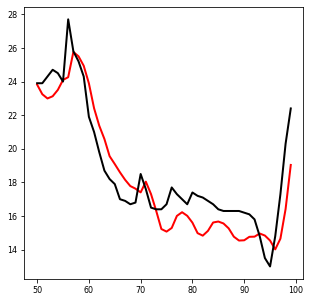

In [18]:
import matplotlib.pyplot as plt
plt.plot(train_results['Test Predictions_original_values'][50:100], 'r')
plt.plot(train_results['Actuals_original_values'][50:100], 'k')